# Post Match (aka Assessment Framework)

In [ ]:
import sys
from pathlib import Path
import pickle
import pandas as pd
import geopandas as gpd
import numpy as np

import src.bikewaysim_functions as bikewaysim_functions

import sys
sys.path.insert(0,str(Path.cwd().parent))
import file_structure_setup
config = file_structure_setup.filepaths()

import impedance_calibration.stochastic_optimization as stochastic_optimization
from network.src import modeling_turns

## ODS

In [ ]:
# import matched ODS (i.e. already have the correct network nodes)
od_matrix = pd.read_csv(config['bikewaysim_fp']/'od_matrix.csv')
ods = list(set(zip(od_matrix['orig_N'],od_matrix['dest_N'])))

In [ ]:
#TODO find how many ods failed to find a shortest path
#od_matrix.loc[od_matrix['current_impedance'].isna(),'trips'].sum()

In [ ]:
# import test case/ base case (think of a better word) network
with (config['calibration_fp']/"calibration_network.pkl").open('rb') as fh:
    links,turns = pickle.load(fh)
# import the calibration results
with (config['calibration_fp']/"calibration_results.pkl").open('rb') as fh:
    calibration_results = pickle.load(fh)
turn_G = modeling_turns.make_turn_graph(turns)


In [ ]:
links['facility_fwd'].unique()

## Export Existing Infra

In [ ]:
existing_infra = links[links['facility_fwd'].notna()]
existing_infra = existing_infra[['linkid','facility_fwd','geometry']].drop_duplicates()
existing_infra.to_file(config['bikewaysim_fp']/'map_layers.gpkg',layer='Existing Bicycle Facilities')

# Network Import

In [ ]:
current_links = gpd.read_file(config['bikewaysim_fp']/'framework_results.gpkg',layer='current_network') 
improvements = gpd.read_file(config['bikewaysim_fp']/'framework_results.gpkg',layer='improvements',ignore_geometry=True)
future_links = gpd.read_file(config['bikewaysim_fp']/'framework_results.gpkg',layer='future_network',ignore_geometry=True)
#TODO can only do this because no new network links were added
links = pd.merge(current_links,future_links[['linkid','reverse_link','multiplier','link_cost']],on=['linkid','reverse_link'])
links.rename(columns={'link_cost_x':'current_link_cost','link_cost_y':'future_link_cost','multiplier_x':'current_multiplier','multiplier_y':'future_multiplier'},inplace=True)
links = pd.merge(links,improvements,on='linkid',how='left')

print(current_links.shape)
print(future_links.shape)
print(links.shape)
print(improvements.shape)

In [ ]:
# del current_links
# del improvements
# del future_links

# Get link impedance reduction from improvements

In [ ]:
print(links['coa_id'].nunique(),'unique projects')

In [ ]:
links[links['coa_id'].notna()].plot()

In [ ]:
links['impedance_reduction'] = links['future_multiplier'] - links['current_multiplier']

In [ ]:
#take the one with the max reduction
links['impedance_reduction'].describe()

In [ ]:
max_impedance_reduction = links[links['impedance_reduction']<0].groupby('linkid')['impedance_reduction'].idxmin()
link_impedance_reduction = links.loc[max_impedance_reduction]
link_impedance_reduction.to_file(config['bikewaysim_fp']/'framework_results.gpkg',layer='link_impedance_reduction')

In [ ]:
undirected_links = links[links['reverse_link']==False]

# Import Routing Results

In [ ]:
with (config['bikewaysim_fp']/"current_shortest_results.pkl").open('rb') as fh:
    shortest_results_dict = pickle.load(fh)

with (config['bikewaysim_fp']/"current_results.pkl").open('rb') as fh:
    current_results_dict = pickle.load(fh)

with (config['bikewaysim_fp']/"future_results.pkl").open('rb') as fh:
    future_results_dict = pickle.load(fh)

Calculate trip travel time/impedance changes

In [ ]:
travel_time_dict = dict(zip(links['linkid'],links['travel_time_min']))

current_tt = {key: np.sum([travel_time_dict.get(edge[0],0) for edge in item['edge_list']]) for key, item in current_results_dict.items()}
future_tt = {key: np.sum([travel_time_dict.get(edge[0],0) for edge in item['edge_list']]) for key, item in future_results_dict.items()}
shortest_tt = {key: np.sum([travel_time_dict.get(edge[0],0) for edge in item['edge_list']]) for key, item in shortest_results_dict.items()}

od_matrix['current_tt_min'] = [current_tt.get(x,np.nan) for x in list((zip(od_matrix['orig_N'],od_matrix['dest_N'])))]
od_matrix['future_tt_min'] = [future_tt.get(x,np.nan) for x in list((zip(od_matrix['orig_N'],od_matrix['dest_N'])))]
od_matrix['shortest_tt_min'] = [shortest_tt.get(x,np.nan) for x in list((zip(od_matrix['orig_N'],od_matrix['dest_N'])))]

current_impedance = {key:item['length'] for key, item in current_results_dict.items()}
future_impedance = {key:item['length'] for key, item in future_results_dict.items()}

od_matrix['current_impedance'] = [current_impedance.get(x,np.nan) for x in list((zip(od_matrix['orig_N'],od_matrix['dest_N'])))]
od_matrix['future_impedance'] = [future_impedance.get(x,np.nan) for x in list((zip(od_matrix['orig_N'],od_matrix['dest_N'])))]

# Impedance Change for trips

Weighted reduction

In [ ]:
od_matrix['impedance_reduction'] = (od_matrix['current_impedance'] - od_matrix['future_impedance'])
maen_reduction = (od_matrix['impedance_reduction'] * od_matrix['trips']).sum() / od_matrix['trips'].sum()
print(f'The weighted average reduction in impedance was {round(maen_reduction,2)} minutes')

In [ ]:
# distribution isn't too meaningful
# import matplotlib.pyplot as plt
# plt.hist(od_matrix['impedance_reduction'],weights=od_matrix['trips'],bins=20)

In [ ]:
max_reduction = od_matrix['impedance_reduction'].max() #* od_matrix['trips']).sum() / od_matrix['trips'].sum()
print(f"The max reduction in impedance was {round(max_reduction,2)} minutes")

In [ ]:
# some difference if aggregating to the destination taz but it's not too different
# trip_impedance_reduction = od_matrix.groupby('dest_taz').apply(lambda x: ((x.current_impedance-x.future_impedance) * x.trips).sum() / x.trips.sum())
# #studyarea = gpd.read_file(config['studyarea_fp'])
# tazs = gpd.read_file(config['bikewaysim_fp']/'map_layers.gpkg',layer='taz_polygons')#,mask=studyarea)
# tazs['impedance_change'] = tazs['tazid'].map(trip_impedance_reduction)
# tazs.plot('impedance_change')

In [ ]:
trip_impedance_reduction = od_matrix.groupby('orig_taz').apply(lambda x: ((x.current_impedance-x.future_impedance) * x.trips).sum() / x.trips.sum())
#studyarea = gpd.read_file(config['studyarea_fp'])
tazs = gpd.read_file(config['bikewaysim_fp']/'ods.gpkg',layer='trip_origins')#,mask=studyarea)
tazs['impedance_change'] = tazs['tazid'].map(trip_impedance_reduction)
tazs.plot('impedance_change')

In [ ]:
tazs[tazs['impedance_change']==0].to_file(config['bikewaysim_fp']/'framework_results.gpkg',layer='origin_weighted_impedance_nochange')
tazs[tazs['impedance_change']>0].to_file(config['bikewaysim_fp']/'framework_results.gpkg',layer='origin_weighted_impedance_change')

# Percent Detour

In [ ]:
# od_matrix['detour'] = od_matrix['current_tt_min'] - od_matrix['shortest_tt_min']
# detour = od_matrix.groupby('orig_taz').apply(lambda x: (x.detour * x.trips).sum() / x.trips.sum())
# #od_matrix.hist(od_matrix['detour'],bins=50,weights=od_matrix['trips'])
# tazs['detour'] = tazs['tazid'].map(detour)
# tazs.plot('detour')

In [ ]:
od_matrix['percent_detour'] = ((od_matrix['current_tt_min'] - od_matrix['shortest_tt_min']) / od_matrix['shortest_tt_min'] * 100)#.round(1)

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Times New Roman'
plt.hist(od_matrix['percent_detour'], bins=range(0, 50, 2), weights=od_matrix['trips'], color='grey')
plt.grid(False)
plt.xlabel(f"Percent Detour (%)")
plt.ylabel(f"Number of Trips (N = {od_matrix['trips'].sum():,})")
# Add vertical red line at the mean value
mean_percent_detour = (od_matrix['percent_detour'] * od_matrix['trips']).sum() / od_matrix['trips'].sum()
plt.axvline(mean_percent_detour, color='red', linestyle='dashed', linewidth=1)
# Add label for the mean value
plt.text(od_matrix['percent_detour'].mean() * 1.5, plt.gca().get_ylim()[1] * 0.9, f"Mean: {mean_percent_detour:,.1f}% detour", color='red', ha='left')
plt.show()

In [ ]:
od_matrix['percent_detour'].describe()

In [ ]:
percent_detour = od_matrix.groupby('orig_taz').apply(lambda x: (x.percent_detour * x.trips).sum() / x.trips.sum())
percent_detour.describe()

In [ ]:
tazs = gpd.read_file(config['bikewaysim_fp']/'ods.gpkg',layer='trip_origins')
tazs['percent_detour'] = tazs['tazid'].map(percent_detour)
tazs.plot('percent_detour')

In [ ]:
tazs.to_file(config['bikewaysim_fp']/'framework_results.gpkg',layer='percent_detour')

## Percent Detour Change Due to Network Improvements (future)

In [ ]:
od_matrix['improved_percent_detour'] = ((od_matrix['future_tt_min'] - od_matrix['shortest_tt_min']) / od_matrix['shortest_tt_min'] * 100)#.round(1)
improved_percent_detour = od_matrix.groupby('orig_taz').apply(lambda x: (x.improved_percent_detour * x.trips).sum() / x.trips.sum())
improved_percent_detour.describe()

In [ ]:
tazs['improved_percent_detour'] = tazs['tazid'].map(improved_percent_detour)

In [ ]:
tazs['percent_detour_change'] = tazs['improved_percent_detour'] - tazs['percent_detour']
tazs['percent_detour_change'].hist()

In [ ]:
# tazs.to_file(config['bikewaysim_fp']/'framework_results.gpkg',layer='percent_detour')

# Link Betweenness Centrality (LBC)
We need this to visualize how trips shifted and to detemrine the impedance reduction contribution of each project.

In [ ]:
#directed is number of trips by direction, undirected is combined number of trips
shortest_undirected_btw_centrality = {key:0 for key in links['linkid'].tolist()}
shortest_directed_btw_centrality = {key:0 for key in list(zip(links['linkid'],links['reverse_link']))}
current_undirected_btw_centrality = {key:0 for key in links['linkid'].tolist()}
current_directed_btw_centrality = {key:0 for key in list(zip(links['linkid'],links['reverse_link']))}
future_undirected_btw_centrality = {key:0 for key in links['linkid'].tolist()}
future_directed_btw_centrality = {key:0 for key in list(zip(links['linkid'],links['reverse_link']))}

dict_keys = list(set.union(set(current_results_dict.keys()),set(future_results_dict.keys())))
for od_pair in dict_keys:
    #get number of trips for that origin node and destinnation node
    o_check = od_matrix['orig_N']==od_pair[0]
    d_check = od_matrix['dest_N']==od_pair[1]
    num_trips = od_matrix.loc[o_check & d_check,'trips'].sum()
    
    #retreive the edge list
    shortest_modeled_edges = shortest_results_dict.get(od_pair,0)
    current_modeled_edges = current_results_dict.get(od_pair,0)
    future_modeled_edges = future_results_dict.get(od_pair,0)
    
    #current
    if shortest_modeled_edges != 0:
        #retrieve the edge list
        shortest_modeled_edges = [tuple(x) for x in shortest_modeled_edges['edge_list']]
        #now add the num trips for each edge in the edge list
        for edge in shortest_modeled_edges:
            shortest_directed_btw_centrality[edge] += num_trips
            shortest_undirected_btw_centrality[edge[0]] += num_trips

    #current
    if current_modeled_edges != 0:
        #retrieve the edge list
        current_modeled_edges = [tuple(x) for x in current_modeled_edges['edge_list']]
        #now add the num trips for each edge in the edge list
        for edge in current_modeled_edges:
            current_directed_btw_centrality[edge] += num_trips
            current_undirected_btw_centrality[edge[0]] += num_trips
    #future
    if future_modeled_edges != 0:
        #retrieve the edge list
        future_modeled_edges = [tuple(x) for x in future_modeled_edges['edge_list']]
        #now add the num trips for each edge in the edge list
        for edge in future_modeled_edges:
            future_directed_btw_centrality[edge] += num_trips
            future_undirected_btw_centrality[edge[0]] += num_trips

#only keep non_zero entries
shortest_undirected_btw_centrality = {key:item for key,item in shortest_undirected_btw_centrality.items() if item > 0}
shortest_directed_btw_centrality = {key:item for key,item in shortest_directed_btw_centrality.items() if item > 0}
current_undirected_btw_centrality = {key:item for key,item in current_undirected_btw_centrality.items() if item > 0}
current_directed_btw_centrality = {key:item for key,item in current_directed_btw_centrality.items() if item > 0}
future_undirected_btw_centrality = {key:item for key,item in future_undirected_btw_centrality.items() if item > 0}
future_directed_btw_centrality = {key:item for key,item in future_directed_btw_centrality.items() if item > 0}            

#turn to dataframe
# directed btw centrality useful for directed bike facilities
df0 = pd.DataFrame.from_dict(shortest_directed_btw_centrality,orient='index',columns=['shortest_btw_centrality'])
df1 = pd.DataFrame.from_dict(current_directed_btw_centrality,orient='index',columns=['current_btw_centrality'])
df2 = pd.DataFrame.from_dict(future_directed_btw_centrality,orient='index',columns=['future_btw_centrality'])
directed_btw_centrality = pd.concat([df0,df1,df2],ignore_index=False,axis=1)
directed_btw_centrality.fillna(0,inplace=True)

df0 = pd.DataFrame.from_dict(shortest_undirected_btw_centrality,orient='index',columns=['shortest_btw_centrality'])
df1 = pd.DataFrame.from_dict(current_undirected_btw_centrality,orient='index',columns=['current_btw_centrality'])
df2 = pd.DataFrame.from_dict(future_undirected_btw_centrality,orient='index',columns=['future_btw_centrality'])
undirected_btw_centrality = pd.concat([df0,df1,df2],ignore_index=False,axis=1)
undirected_btw_centrality.fillna(0,inplace=True)
undirected_btw_centrality.reset_index(inplace=True)
undirected_btw_centrality.rename(columns={'index':'linkid'},inplace=True)

#calculate the change
directed_btw_centrality['impedance_change'] = directed_btw_centrality['current_btw_centrality'] - directed_btw_centrality['shortest_btw_centrality']
undirected_btw_centrality['impedance_change'] = undirected_btw_centrality['current_btw_centrality'] - undirected_btw_centrality['shortest_btw_centrality']

directed_btw_centrality['improvement_change'] = directed_btw_centrality['future_btw_centrality'] - directed_btw_centrality['current_btw_centrality']
undirected_btw_centrality['improvement_change'] = undirected_btw_centrality['future_btw_centrality'] - undirected_btw_centrality['current_btw_centrality']

#and pct change
#undirected_btw_centrality['pct_change'] = undirected_btw_centrality['change'] / undirected_btw_centrality['current_btw_centrality'] * 100


In [ ]:
#add geometry data
undirected_btw_centrality_gdf = pd.merge(undirected_btw_centrality,undirected_links,on='linkid')
undirected_btw_centrality_gdf = gpd.GeoDataFrame(undirected_btw_centrality_gdf,geometry='geometry',crs=config['projected_crs_epsg'])

In [ ]:
undirected_btw_centrality_gdf[undirected_btw_centrality_gdf['impedance_change']!=0].plot('impedance_change')

In [ ]:
undirected_btw_centrality_gdf[undirected_btw_centrality_gdf['improvement_change']!=0].plot('improvement_change')

In [ ]:
undirected_btw_centrality_gdf[['shortest_btw_centrality','current_btw_centrality']]

In [ ]:
undirected_btw_centrality_gdf.columns

In [ ]:
undirected_btw_centrality_gdf.max()

In [ ]:
#travel time lbc
undirected_btw_centrality_gdf[undirected_btw_centrality_gdf['shortest_btw_centrality']!=0].to_file(config['bikewaysim_fp']/'framework_results.gpkg',layer='lbc_shortest')
undirected_btw_centrality_gdf[undirected_btw_centrality_gdf['current_btw_centrality']!=0].to_file(config['bikewaysim_fp']/'framework_results.gpkg',layer='lbc_current')
undirected_btw_centrality_gdf[undirected_btw_centrality_gdf['future_btw_centrality']!=0].to_file(config['bikewaysim_fp']/'framework_results.gpkg',layer='lbc_future')




#current with impedance lbc
#compare to 
#undirected_btw_centrality_gdf[undirected_btw_centrality_gdf['current_btw_centrality']!=0].to_file(config['bikewaysim_fp']/'framework_results.gpkg',layer='current_lbc')

# impedance_change = undirected_btw_centrality_gdf.copy()
# impedance_change.loc[undirected_btw_centrality_gdf['impedance_change']==0,'change_cat'] = 'No Change'
# impedance_change.loc[undirected_btw_centrality_gdf['impedance_change']>0,'change_cat'] = 'Increase'
# impedance_change.loc[undirected_btw_centrality_gdf['impedance_change']<0,'change_cat'] = 'Decrease'
# impedance_change.to_file(config['bikewaysim_fp']/'framework_results.gpkg',layer='impedance_change_lbc')

undirected_btw_centrality_gdf.to_file(config['bikewaysim_fp']/'framework_results.gpkg',layer='lbc_impedance_change')
undirected_btw_centrality_gdf.to_file(config['bikewaysim_fp']/'framework_results.gpkg',layer='lbc_improvement_change')

In [ ]:
# undirected_btw_centrality_gdf[undirected_btw_centrality_gdf['improvement_change']!=0].to_file(config['bikewaysim_fp']/'framework_results.gpkg',layer='improvement_change_lbc')

## Impedance Reduction Contribution 

### Method 1: Multiply Link Impedance Reduction by Betweenness Centrality for the Improved Links

In [73]:
undirected_btw_centrality_gdf['impedance_contribution'] = undirected_btw_centrality_gdf['impedance_reduction'] * undirected_btw_centrality_gdf['future_btw_centrality']
undirected_btw_centrality_gdf['length'] = undirected_btw_centrality_gdf.length

bike_facility = undirected_btw_centrality_gdf[undirected_btw_centrality_gdf['coa_id'].notna()]
bike_facility_geo = bike_facility.dissolve('coa_id')[['geometry']]
impedance_contribution = bike_facility.groupby('coa_id')[['impedance_contribution','length']].sum().abs()

impedance_contribution = pd.concat([impedance_contribution,bike_facility_geo],axis=1,ignore_index=False)

In [74]:
impedance_contribution['impedance_contribution_per_ft'] = impedance_contribution['impedance_contribution'] / impedance_contribution['length']

In [75]:
impedance_contribution = gpd.GeoDataFrame(impedance_contribution,crs=config['projected_crs_epsg'])

<AxesSubplot: >

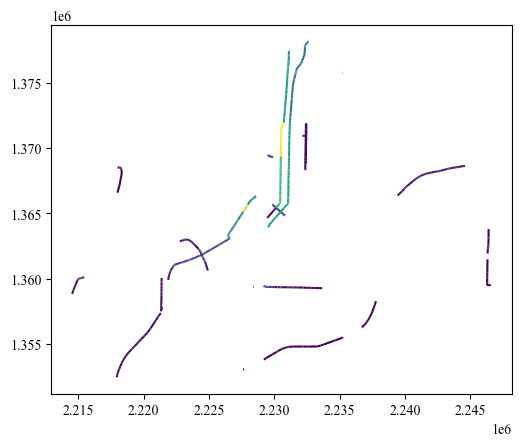

In [76]:
impedance_contribution.plot('impedance_contribution_per_ft')

In [77]:
coa_facilities = gpd.read_file(config['bicycle_facilities_fp']/'network_modifications.gpkg',layer='coa')[['coa_id','coa_name','coa_osm_type']]
impedance_contribution = pd.merge(impedance_contribution,coa_facilities,on='coa_id')

In [81]:
impedance_contribution.columns

Index(['coa_id', 'impedance_contribution', 'length', 'geometry',
       'impedance_contribution_per_ft', 'coa_name', 'coa_osm_type'],
      dtype='object')

In [89]:
impedance_contribution = impedance_contribution[['coa_name','coa_osm_type','impedance_contribution_per_ft','impedance_contribution', 'length']]
impedance_contribution['impedance_contribution_per_ft'] = impedance_contribution['impedance_contribution_per_ft'].astype(int)
impedance_contribution['length'] = impedance_contribution['length'].astype(int)
impedance_contribution.sort_values('impedance_contribution_per_ft',ascending=False).to_csv(config['bikewaysim_fp']/'impedance_contribution.csv',index=False)

In [ ]:
impedance_contribution.to_file(config['bikewaysim_fp']/'framework_results.gpkg',layer='impedance_contribution')

In [ ]:
impedance_contribution = bike_facility.groupby('coa_id')[['impedance_contribution','length']].sum().abs()
#impedance_contribution = (impedance_contribution['impedance_contribution'] / impedance_contribution['length']).sort_values()

In [ ]:
impedance_contribution

In [ ]:
undirected_btw_centrality_gdf['improvement_impedance_reduction'] = undirected_btw_centrality_gdf['coa_id'].map(test)

In [ ]:
undirected_btw_centrality_gdf[undirected_btw_centrality_gdf['coa_id'].notna()].to_file(config['bikewaysim_fp']/'framework_results.gpkg',layer='improvement_impedance_reduction')
undirected_btw_centrality_gdf[undirected_btw_centrality_gdf['coa_id'].isna()]

In [ ]:

#import the ones with names too
improvements

In [ ]:
improvements[['facility_fwd_new','coa_id']].drop_duplicates()

In [ ]:
test['impedance_reduction'] (undirected_btw_centrality_gdf['future_link_cost'] - undirected_btw_centrality_gdf['current_link_cost'])

In [ ]:
undirected_links

In [ ]:
improvements.head()

In [ ]:
undirected_btw_centrality_gdf.head()

In [ ]:
test = pd.merge(test,facility_ids,on='linkid',how='left')

In [ ]:
test['impedance_change_cont'] = test['counts'] * test['impedance_change']

In [ ]:
#import the coa id back in so that we can aggregate by the faciility
facility_ids = gpd.read_file(config['bicycle_facilities_fp']/"network_improvements.gpkg",layer='coa')[['coa_id','linkid']]

In [ ]:
result = test[test['impedance_change_cont']>0].groupby(['coa_id','improvement'])['impedance_change_cont'].sum().sort_values(ascending=False)
result.reset_index(inplace=True)

In [ ]:
facility_ids = gpd.read_file(config['bicycle_facilities_fp']/"network_improvements.gpkg",layer='coa')
facility_ids = facility_ids.dissolve('coa_id').reset_index()

In [ ]:
facility_ids = pd.merge(facility_ids,result,on='coa_id')
facility_ids.explore('impedance_change_cont')

In [ ]:
results_dict

In [ ]:
#od_matrix['current_impedance'] = 
results_dict.apply(lambda x: current_results_dict.get((x['origin_N'],),axis=1)

In [ ]:
# find the impedance for each trip

In [ ]:
results_dict[(6846937343, 5416049647)].keys()

In [ ]:
#figure out why this is na
pd.Series([item['length'] for key, item in results_dict.items()]).isna().sum()

In [ ]:
pd.Series([item['length'] for key, item in results_dict.items()]).isna().sum()

In [ ]:
len(results_dict)

In [ ]:
# get the results and assigned to ods (store edge sequence in a dict soemwehre)
ods.map(results_dict)

In [ ]:
# calculate btwn centrality



In [ ]:
# import test case/ base case (think of a better word) network
with (config['calibration_fp']/"calibration_network.pkl").open('rb') as fh:
    links,turns = pickle.load(fh)
# import the calibration results
with (config['calibration_fp']/"calibration_results.pkl").open('rb') as fh:
    calibration_results = pickle.load(fh)
turn_G = modeling_turns.make_turn_graph(turns)